In [23]:
#Importing Relevant Libraries
## General
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import random

## Setting up Model/Metrics and Loss Functions
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import Model, Input
from keras.losses import binary_crossentropy
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Add, Dropout, UpSampling2D, Conv2DTranspose, Concatenate
## Formatting and Displaying Images
import os
import cv2 as cv
import glob
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from PIL import Image
from sklearn.utils import shuffle

## Loss Functions and Metrics

In [24]:
#LOSS FUNCTIONS

#Jacquard Loss
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 multiplied as we want to minimize this value as loss function

#Dice Loss
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Binary Cross Entropy
binary_ce = tf.keras.losses.BinaryCrossentropy()

#Weighted Binary Cross Entropy
def weighted_bce(y_true, y_pred):
    num_pred = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) + K.sum(y_true)
    zero_weight =  K.sum(y_true)/ num_pred +  K.epsilon() 
    one_weight = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) / num_pred +  K.epsilon()
    weights =  (1.0 - y_true) * zero_weight +  y_true * one_weight 
    bin_crossentropy = K.binary_crossentropy(y_true, y_pred)
    weighted_bin_crossentropy = weights * bin_crossentropy 
    return K.mean(weighted_bin_crossentropy)

#Focal Loss
def binary_focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(p_t)
    weight = alpha_t * K.pow((1-p_t), gamma)
    loss = weight * cross_entropy
    focal_loss = K.sum(loss, axis=1)
    return focal_loss

#Tversky Loss
def binary_tversky_loss(y_true, y_pred, beta=0.7, smooth=1.0):
    axis_to_reduce = range(1, K.ndim(y_pred)) 
    numerator = K.sum(y_true * y_pred, axis=axis_to_reduce) 
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  
    denominator = K.sum(denominator, axis=axis_to_reduce)
    tversky_coeff = (numerator + smooth) / (denominator + smooth)  
    return 1-tversky_coeff

#Focal Tversky Loss
def focal_tversky(y_true, y_pred):
    epsilon = 1e-5
    smooth = 1.
    alpha = 0.7
    gamma = 0.75
    
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    tversky = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    return K.pow((1-tversky), gamma)

#Combo Loss
# def combo_loss(y_true, y_pred, smooth=1):
#     e = K.epsilon()
#     if y_pred.shape[-1] <= 1:
#         ALPHA = 0.3    # < 0.5 penalises FP more, > 0.5 penalises FN more
#         CE_RATIO = 0.5 # weighted contribution of modified CE loss compared to Dice loss
#         y_pred = tf.keras.activations.sigmoid(y_pred)
#     elif y_pred.shape[-1] >= 2:
#         ALPHA = 0.3    # < 0.5 penalises FP more, > 0.5 penalises FN more
#         CE_RATIO = 0.7 # weighted contribution of modified CE loss compared to Dice loss
#         y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
#         y_true = K.squeeze(y_true, 3)
#         y_true = tf.cast(y_true, "int32")
#         y_true = tf.one_hot(y_true, num_class, axis=-1)
 
#  # cast to float32 datatype
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
 
#     targets = K.flatten(y_true)
#     inputs = K.flatten(y_pred)
 
#     intersection = K.sum(targets * inputs)
#     dice = (2. * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
#     inputs = K.clip(inputs, e, 1.0 - e)
#     out = - (ALPHA * ((targets * K.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * K.log(1.0 - inputs))))
#     weighted_ce = K.mean(out, axis=-1)
#     combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)

#     return combo

ce_w = 0.5
ce_d_w = 0.5
e = K.epsilon()
smooth = 1
'''
ce_w values smaller than 0.5 penalize false positives more while values larger than 0.5 penalize false negatives more
ce_d_w is level of contribution of the cross-entropy loss in the total loss.
'''

def Combo_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    d = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    y_pred_f = K.clip(y_pred_f, e, 1.0 - e)
    out = - (ce_w * y_true_f * K.log(y_pred_f)) + ((1 - ce_w) * (1.0 - y_true_f) * K.log(1.0 - y_pred_f))
    weighted_ce = K.mean(out, axis=-1)
    combo = (ce_d_w * weighted_ce) - ((1 - ce_d_w) * d)
    return combo

def clip(z):
    """ Clip all values in a tensor to prevent divide by 0 errors. """
    z = K.clip(z, 1e-7, 1)
    return z

def dice_wpce_loss(y_true, y_pred):
    # Get weighted pixel cross entropy loss
    # Assign a greater loss to false negative predictions to prevent model always predicting y = 0 for all pixels
    num_pred = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) + K.sum(y_true)
    zero_weight =  K.sum(y_true)/ num_pred +  K.epsilon() 
    one_weight = K.sum(K.cast(y_pred > 0.5, y_true.dtype)) / num_pred +  K.epsilon()
    weights =  (1.0 - y_true) * zero_weight +  y_true * one_weight  
    batch_size=16
    px_wt = 1. / weights
    # Find the number of total pixels in an image
    num_pix = K.int_shape(y_pred)[1] * K.int_shape(y_pred)[2]
    bce = - ((px_wt * y_true * K.log(clip(y_pred))) + (1 - y_true) * K.log(clip(1 - y_pred)))

    # Sum and average the loss by the number of pixels and by the batch size
    wpce_loss = (K.sum(bce) / num_pix) / batch_size

    # Compute dice coefficient and return loss
    _dice_loss = dice_coef_loss(y_true, y_pred)
    
    # The final loss value is a mix of both loss functions
    loss = _dice_loss + wpce_loss

    return loss

In [25]:
#METRICS
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coef(y_true,y_pred):
    inters = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice = (2. * inters + 1) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + 1)
    return dice

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def specificity(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

miou = tf.keras.metrics.MeanIoU(num_classes=2)

def binary_accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

## Formatting Dataset
- Input Dimensions: 256 x 256 x 3 (H X W X C)

In [26]:
# Paths for Train and Test Images
TRAIN_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_256/Training Set/'
TEST_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_256/Test Set/'

#Saving file names (without paths) of training and testing images in list
train_ids = os.listdir(TRAIN_PATH + 'original/') #908 file names
test_ids = os.listdir(TEST_PATH + 'original/') #303 file names

#Sample filenames saved
print(f'Sample file names from training set: {train_ids[0:5]}')
print(f'Sample file names from test set: {test_ids[0:5]}')

Sample file names from training set: ['F030a09-8.jpg', 'F007a04-22.jpg', 'F011a01-23.jpg', 'F034a09-17.jpg', 'F018a02-9.jpg']
Sample file names from test set: ['F033a17-20.jpg', 'F018a05-22.jpg', 'F033a14-8.jpg', 'F017a09-21.jpg', 'F007a05-4.jpg']


#### Reading, Storing and Normalizing Training and Testing Images

In [27]:
print('Reading and Storing training images and masks')
X_trainf = []
Y_trainf = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
   img = imread(TRAIN_PATH + '/original/' + id_)
   X_trainf.append(img)
   mask = imread(TRAIN_PATH + '/Mask/' + id_ )
   Y_trainf.append((mask/ 255).reshape(256, 256, 1))

  4%|▍         | 50/1211 [00:00<00:02, 495.84it/s]

Reading and Storing training images and masks


100%|██████████| 1211/1211 [00:02<00:00, 499.80it/s]


In [28]:
print('Reading and Storing test images and masks')

X_test = []
Y_test = []       

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  img1 = imread(TEST_PATH + '/original/' + id_ )
  X_test.append(img1)
  mask1 = imread(TEST_PATH  + '/Mask/' + id_ )
  Y_test.append((mask1/ 255).reshape(256, 256, 1))

 17%|█▋        | 52/303 [00:00<00:00, 510.20it/s]

Reading and Storing test images and masks


100%|██████████| 303/303 [00:00<00:00, 496.07it/s]


### Creating validation set and splitting entire dataset to be in 60-20-20 ratio
- 908 training images
- 303 testing images
- 303 validation images (taken from the test set)

In [7]:
# full_train_label = np.copy(Y_trainf)
# val_set_len = 303
# val_train = []
# val_test = []

# #Randomly selecting 303 images from the training set and simultaneously deleting the selected images from the training set
# #to ensure there are no repeats between the two sets
# for i in range(val_set_len):
#     index = random.randint(0, len(X_trainf)-1)
#     val_train.append(X_trainf[index])
#     X_trainf.pop(index)
#     val_test.append(Y_trainf[index])
#     Y_trainf.pop(index)
    
# print(f'Number of imaages in training set: {len(X_trainf)}')
# print(f'Number of images in the validation set: {len(val_train)}')

In [29]:
#Normalizing images in the 3 sets and converting them to numpy arrays to be compatible with the model
X_train = np.array(X_trainf)/255
X_test = np.array(X_test)/255
# val_train = np.array(val_train)/255

#Converting masks to numpy arrays to be compatible with the model
Y_train = np.array(Y_trainf)
Y_test = np.array(Y_test)
# val_test = np.array(val_test)

#Getting rid of the 1 in 256x256x1 of the masks in each set so that mask dimension is reduced to 256x256
Y_train  = Y_train[:,:,:,0]
Y_test  = Y_test[:,:,:,0]
# val_test = val_test[:,:,:,0]

In [30]:
#Checking to see if dataset dimensions are correct
#Format: No. of images/Batch Size x Height x Width x Channel
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (1211, 256, 256, 3)
Y_train = (1211, 256, 256)
X_test  = (303, 256, 256, 3)
Y_test  = (303, 256, 256)


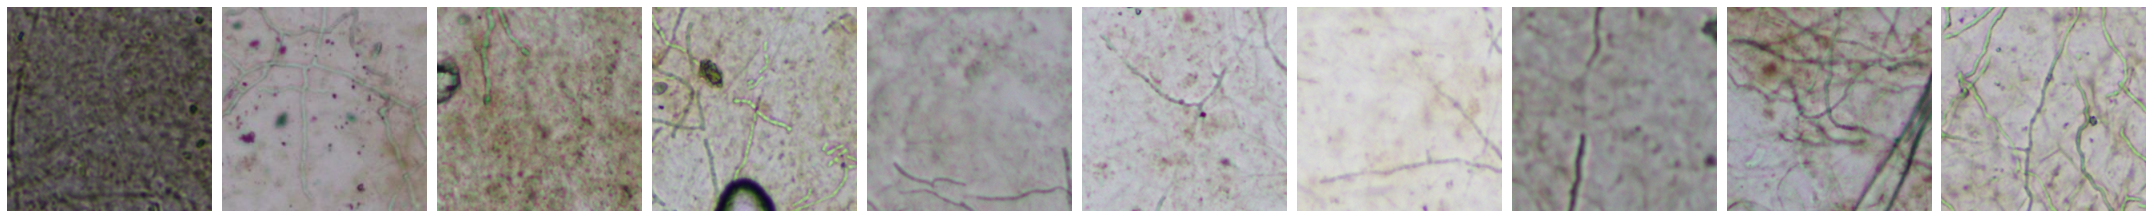

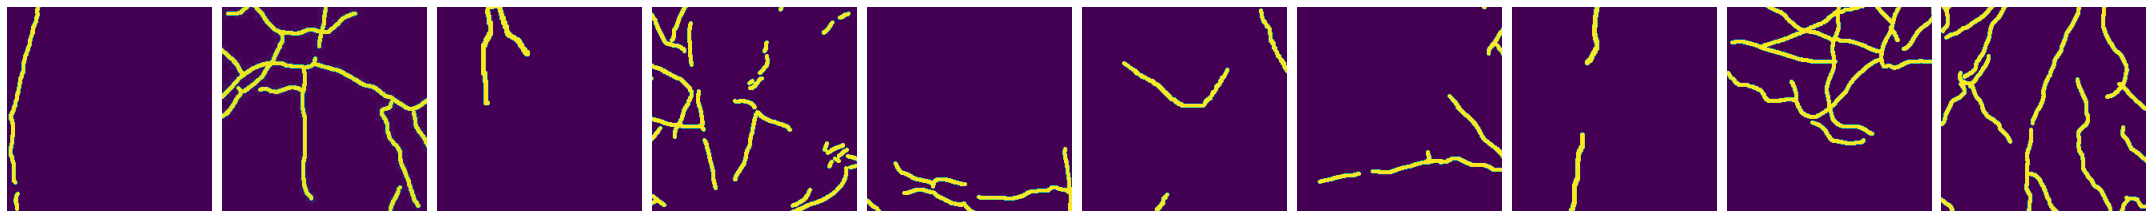

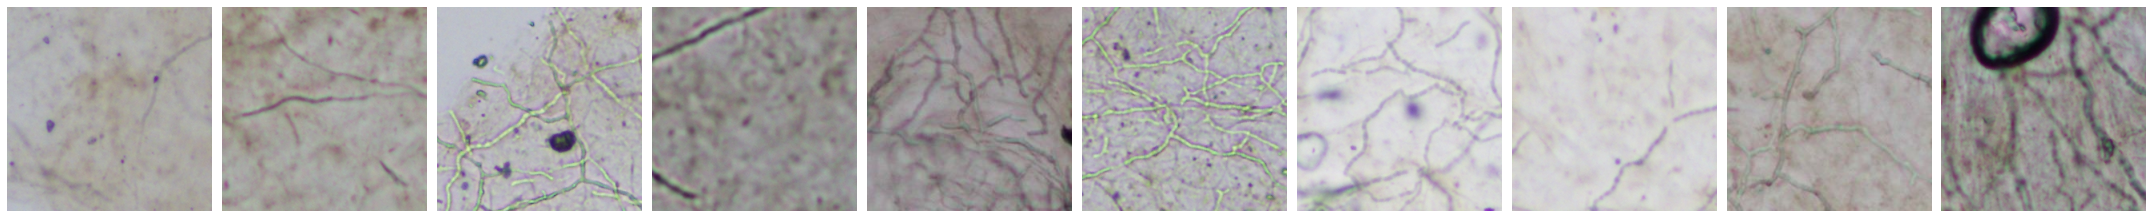

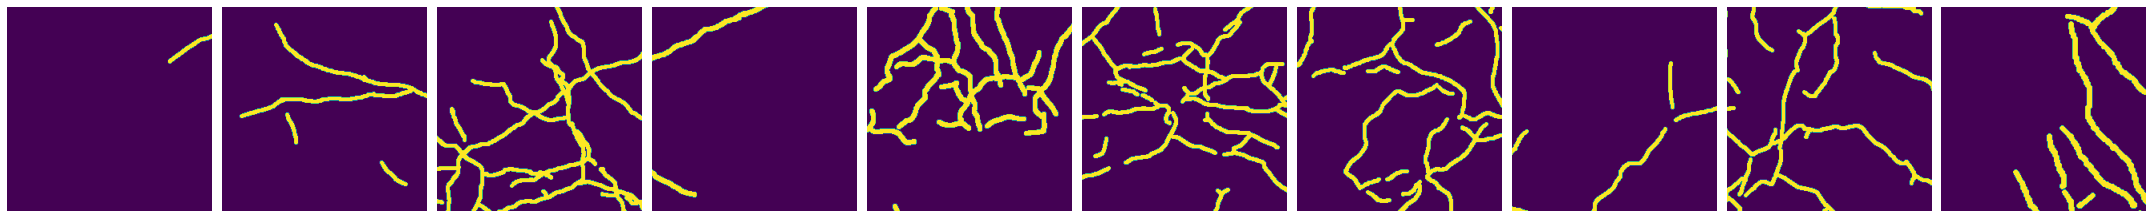

In [31]:
#Displaying training and testing images and masks after formating
def plotImages(images_arr, num_plots = 5):
    fig, axes = plt.subplots(1, num_plots, figsize=(30, 30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# plot images
plotImages(X_train,10)
plotImages(Y_train,10)
plotImages(X_test,10)
plotImages(Y_test,10)

### Formatting for RGB Channnel Input Dataset [Not Required]

In [12]:
#BGR Order for imshow
## X_train
X_train_b = X_train[:,:,:,0]
X_train_g = X_train[:,:,:,1]
X_train_r = X_train[:,:,:,2]
print(X_train_b.shape, X_train_g.shape, X_train_r.shape)

(1211, 256, 256) (1211, 256, 256) (1211, 256, 256)


In [13]:
## X_test, val_train
X_test_b = X_test[:,:,:,0]
X_test_g = X_test[:,:,:,1]
X_test_r = X_test[:,:,:,2]
print(X_test_b.shape, X_test_g.shape, X_test_r.shape)

val_train_b = val_train[:,:,:,0]
val_train_g = val_train[:,:,:,1]
val_train_r = val_train[:,:,:,2]
print(val_train_b.shape, val_train_g.shape, val_train_r.shape)

(303, 256, 256) (303, 256, 256) (303, 256, 256)


NameError: name 'val_train' is not defined

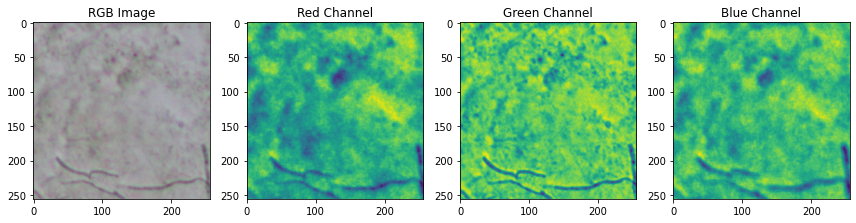

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(141)
plt.imshow(X_train[4])
plt.title('RGB Image')
plt.subplot(142)
plt.imshow(X_train_r[4])
plt.title('Red Channel')
plt.subplot(143)
plt.imshow(X_train_g[4])
plt.title('Green Channel')
plt.subplot(144)
plt.imshow(X_train_b[4])
plt.title('Blue Channel')
plt.tight_layout()

## Model Definition - Residual Attention

### Model Blocks

In [32]:
#Formatting
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)
    
def pad_depth(small, big):
    y = K.zeros_like(big)
    new_channels = big.shape.as_list()[-1] - small.shape.as_list()[-1]
    y = y[:,:, :, :new_channels]
    return concatenate([small,y])
    
#########################

# #SQUEEZE AND EXCITATION BLOCK
# def se_block(in_block, ch, ratio=16):
#     x =  tf.keras.layers.GlobalAveragePooling2D()(in_block)
#     x =  tf.keras.layers.Dense(ch//ratio, activation='relu')(x)
#     x =  tf.keras.layers.Dense(ch, activation='sigmoid')(x)
#     return tf.keras.layers.Multiply()([in_block, x])

#GENERATING GATING SIGNAL FOR ATTENTION GATING
def gating_signal(input, filter_prod):
    block_f = FILTER*filter_prod
    x = Conv2D(block_f, (1, 1), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

#ATTENTION GATING (in Skip Connections)
def attention_block(x, gating, filter_prod):
    inter_shape = FILTER*filter_prod
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='valid')(x) 
    shape_theta_x = K.int_shape(theta_x)
    concat_xg = Add()([gating, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  
    upsample_psi = expend_as(upsample_psi, shape_x[3])
    y = tf.keras.layers.Multiply()([upsample_psi, x])
    result_bn = BatchNormalization()(y)
    return result_bn

### Encoder and Decoder Blocks

In [33]:
#RESIDUAL DECODER - BASIC
def encoder_block(x1, filter_prod):
    "x1 = input to be added in residual block"
    "filter_prod = to modify FILTER as we go deeper in the model"
    block_f = FILTER*filter_prod
    conv1 = Conv2D(block_f, 3, padding ='same', kernel_initializer='he_normal')(x1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(block_f, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
#     se1 = se_block(conv1, block_f)
    pd1 = pad_depth(x1, conv1) #---> formatting for channel matching
    res1 =  Add()([x1, conv1])   
    res1 =  Activation('relu')(res1)
    drop1 = Dropout(dropout_val)(res1)
    return drop1

def decoder_block (x, g, filter_prod):
    block_f = FILTER*filter_prod
#     se2 = se_block(x, block_f)
    gate1 = gating_signal(g, filter_prod)
    att1 = attention_block(x, gate1, filter_prod)
    up1 = UpSampling2D(size=(2,2))(g)
    cat1 = Concatenate(axis = axis)([up1, att1]) #Input to the decoder block after skip connection mechanism
    conv3 = Conv2D(block_f, 3, padding ='same', kernel_initializer='he_normal')(cat1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(block_f, 3, padding ='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    drop3 = Dropout(dropout_val)(conv3)
    shortcut = Conv2D(block_f, kernel_size=(1, 1), padding='same')(cat1) #---> formatting for channel matching
    res2 =  Add()([shortcut, drop3]) 
    return drop3

## Model Definition

In [34]:
FILTER = 64
axis = 3
dropout_val = 0.1

def attn_unet():
    input = Input(shape=(256,256,3)) # 256, 256, 3
    #ENCODER ARM
    e1 = encoder_block(input, 1) # 128, 128, 64
    pool1 = MaxPooling2D(pool_size=(2, 2))(e1)
    e2 = encoder_block(pool1, 2 ) #64, 64, 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(e2)
    e3 = encoder_block(pool2, 4)# 32, 32, 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(e3)
    e4 = encoder_block(pool3, 8)# 16, 16, 512
    pool4 = MaxPooling2D(pool_size=(2, 2))(e4)
    #Bottle Neck
    e5 = encoder_block(pool4, 16)# 8, 8, 1024
    
    #DECODER ARM
    u1 = decoder_block(e4, e5, 8) #16, 16, 512
    u2 = decoder_block(e3, u1, 4)
    u3 = decoder_block(e2, u2, 2)
    u4 = decoder_block(e1, u3, 1)
    
    output = Conv2D(1, 1, activation = 'sigmoid')(u4)
    model = Model(inputs = input ,outputs = output)
    
    #Optimizer
    adam=tf.keras.optimizers.Adam( learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(optimizer = adam, loss = [binary_ce], metrics = [[jacard_coef, f1_m, precision_m, recall_m, dice_coef, 'accuracy', miou, specificity]])
    model.summary()
    return model

## Model Training

In [35]:
#Creating a dataframe to track hyperparameters set
df = pd.DataFrame()
col_names = ['Model', 'History', 'LR', 'BATCH', 'es_patience', 'es_mindelta', 'rlr_patience', 'rlr_mindelta']
df = pd.DataFrame(columns=col_names)

### Setting Training Parameters

In [36]:
# File name of model and history file
fname_model = 'Att_Unet_bce_trial_10x.h5'
fname_history = 'Att_Unet_bce_trial_10x.csv'

In [37]:
#Training Parameters
LR = 0.001
es_patience = 7
es_mindelta = 0.01
rlr_patience = 2
rlr_mindelta = 0.01
BATCH = 16

#Storing in a list to append to dataframe after training
entry = [fname_model, fname_history, LR, BATCH, es_patience, es_mindelta, rlr_patience, rlr_mindelta]

In [38]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Att_Unet_bce_trial.h5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(patience = es_patience, monitor='val_loss', min_delta=es_mindelta)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose = 1, min_delta=rlr_mindelta, factor = 0.1, patience =rlr_patience, mode='min', min_lre =  0.00001)
                                                 
callbacks = [checkpointer, earlystopper, reduce_LR]                                    
##############
model = attn_unet()
##############
history1  = model.fit(X_train, Y_train
                    , batch_size=BATCH
                    , epochs=200
                    , validation_split=0.3
                    , shuffle=True
                    #,validation_data=(val_train, val_test)
                    #, class_weight=weights
                    # , use_multiprocessing=True
                    , verbose = 1
                    , callbacks=callbacks
                   )

ValueError: Operands could not be broadcast together with shapes (256, 256, 3) (256, 256, 64)

## Saving Model and History File

In [22]:
#Saving Model
file_name_m = f'/home/keerthanaprasad/RajithaKV/Data_256_Unet/{fname_model}'
model.save(file_name_m)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history1.history) 
hist_csv_file = fname_history
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Plotting Accuracy and Loss Curves for Model
- Plotting Accuracy and Loss curves for saved model shown later in the notebook

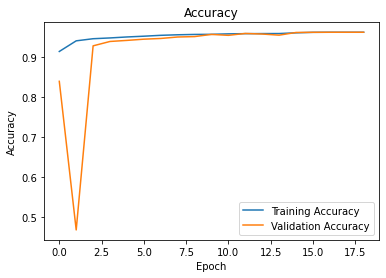

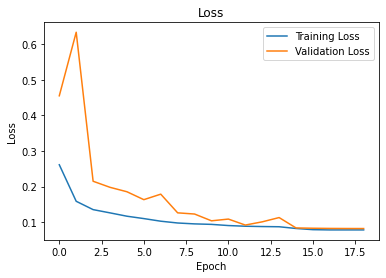

In [23]:
hist = history1.history

#Accuracy Curve
plt.figure()
plt.plot(hist['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.figure(1)
plt.plot(hist['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"], loc ="lower right")

#Loss Curve
plt.figure()
plt.plot(hist['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(hist['val_loss'][:])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"], loc ="upper right")
plt.show()

In [24]:
#Appending  training parameters to dataframe for tracking
df.loc[len(df)] = entry

# Drop Entry
# df = df.drop(1)

#Saving Df as CSV
# df.to_csv('file1.csv')
df

,Model,History,LR,BATCH,es_patience,es_mindelta,rlr_patience,rlr_mindelta
0,attres_bce.h5,history_attres_bce.csv,0.001,16,7,0.01,2,0.01


## Loading Saved Model and Evaluation

In [ ]:
#attres_dec_wpc1.h5 --> best performing model

In [10]:
from keras.models import load_model
new_model = load_model('/home/keerthanaprasad/RajithaKV/Data_256_Unet/attres_bce.h5',custom_objects={'jacard_coef_loss':jacard_coef_loss, 
                                                                                                         'jacard_coef': jacard_coef, 'f1_m':f1_m, 'precision_m':precision_m, 
                                                                                                         'recall_m':recall_m, 'dice_coef':dice_coef, 'binary_focal_loss':binary_focal_loss, 'specificity':specificity, 'dice_wpce_loss':dice_wpce_loss, 'dice_coef_loss':dice_coef_loss, 'binary_tversky_loss':binary_tversky_loss, 'focal_tversky':focal_tversky,
                                                                                                     'weighted_bce': weighted_bce})

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

## Plotting Accuracy and Loss Curves for Saved Models 

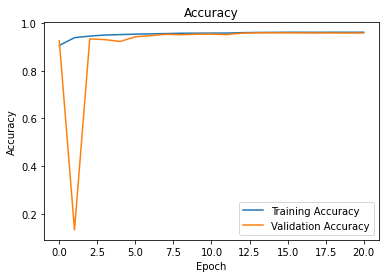

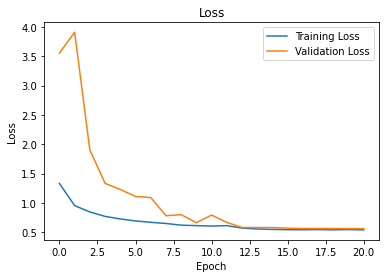

In [55]:
#Loading History File
df = pd.read_csv("history_attres_dec_wpc1.csv",index_col=[0]) 
epochs = list(range(0,len(df.index)))  

acc = df['accuracy'].to_numpy()
loss = df['loss'].to_numpy()
val_acc =df['val_accuracy'].to_numpy()
val_loss=df['val_loss'].to_numpy()
mmiou = df['mean_io_u'].to_numpy()
val_mmiou = df['val_mean_io_u'].to_numpy()

#Accuracy
plt.plot(epochs,acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"], loc ="lower right")
plt.show()

#Loss
plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss","Validation Loss"], loc ="upper right")
plt.show()

# #MIOU
# plt.plot(epochs,mmiou)
# plt.title('Model MIOU')
# plt.xlabel('Epoch')
# plt.ylabel('MIOU')
# plt.plot(epochs,val_mmiou)
# plt.legend(["Training MIOU", "Validation MIOU"], loc ="lower right")
# plt.show()

### Finding Best Threshold

In [26]:
#Using Validation Set for Selecting Best Threshold
preds_val_test = new_model.predict(val_train, verbose=1)

10/10 [==============================] - 3s 290ms/step


In [30]:
# #Best threshold based on Dice Score

# thresholds = np.arange(0, 1, 0.01) #100 terms
# scores = []

# print('\n---Finding Dice Score based Threshold---')
# for t in tqdm(thresholds):
#     scores.append(np.around(dice_coef(val_test.flatten(), to_labels(preds_val_test,t)),3))
# ix = np.argmax(scores)
# print('Threshold=%.3f, Dice Score.=%.5f' % (thresholds[ix], scores[ix]))
# dice_thresh = thresholds[ix]

In [31]:
# Best Threshold based on Jaccard score
def to_labels(probs, threshold):
    a = (probs > threshold).astype(np.uint8)
    a = a.astype(float)
    return a.flatten()

thresholds = np.arange(0, 1, 0.01) #100 terms
scores = []

print('\n---Finding Jaccard Score based Threshold---')
for t in tqdm(thresholds):
    scores.append(np.around(jacard_coef(val_test.flatten(), to_labels(preds_val_test,t)),3))
ix = np.argmax(scores)
print('Threshold=%.3f, Jaccard Coef.=%.5f' % (thresholds[ix], scores[ix]))

  0%|          | 0/100 [00:00<?, ?it/s]


---Finding Jaccard Score based Threshold---


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]

Threshold=0.350, Jaccard Coef.=0.55200


### Thresholding 

In [32]:
preds_test = new_model.predict(X_test, verbose=1)

#Thresholding
# preds_test_t = (preds_test>thresholds[ix]).astype(np.uint8) #Based on best jaccard score
preds_test_b = (preds_test>0.5).astype(np.uint8) #Default threshold = 0.5
# preds_test_d = (preds_test>dice_thresh).astype(np.uint8)

#Formatting
preds_test = preds_test.astype(float)
# preds_test_t = preds_test_t.astype(float)
preds_test_b = preds_test_b.astype(float)

10/10 [==============================] - 3s 322ms/step


### Plotting Images
- To save each image in each interation of the for loop uncomment plt.savefig after putting the correct path and run the cell

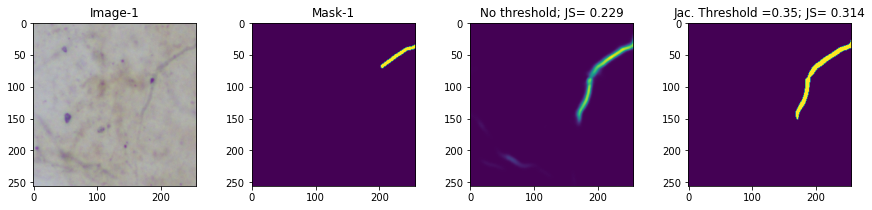

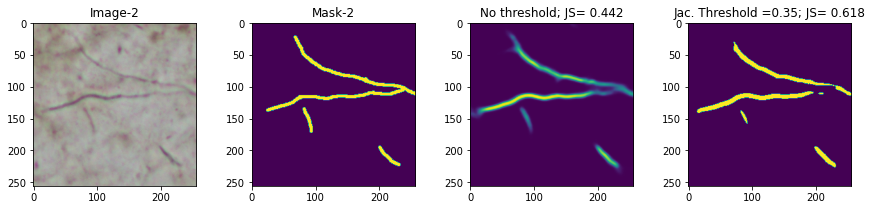

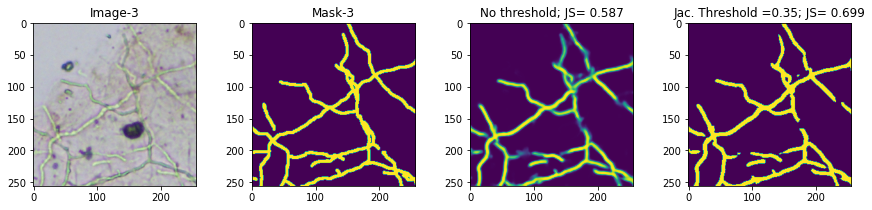

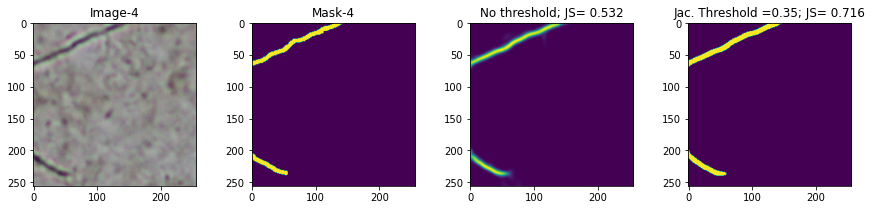

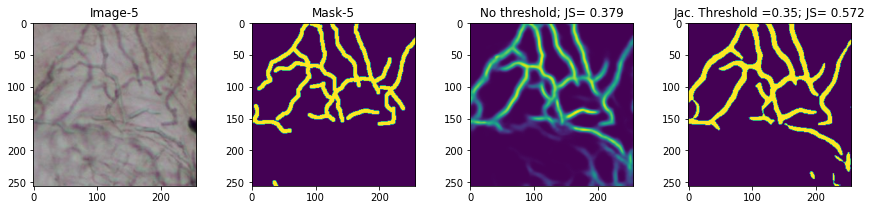

In [33]:
num_of_images = len(X_test) #Set Number of Test Images you want to display/save

for i in range(5):
    plt.figure(figsize=(15,3))
#   plt.suptitle('Residual Attention', fontsize = 13, fontweight="bold", y=1.005)
    plt.subplot(1,4,1)
    plt.imshow(X_test[i])
    plt.title(f'Image-{i+1}')
    plt.subplot(1,4,2)
    plt.imshow(Y_test[i])
    plt.title(f'Mask-{i+1}')
    plt.subplot(1,4,3)
    plt.imshow(preds_test[i,:,:,0])
    plt.title('No threshold; JS= ' + str(np.around(jacard_coef(Y_test[i], preds_test[i,:,:,0]), 3)))    
    plt.subplot(1,4,4)
    plt.imshow(preds_test_b[i,:,:,0])
    plt.title(f'Jac. Threshold =0.5; JS= ' + str(np.around(jacard_coef(Y_test[i], preds_test_b[i,:,:,0]), 3)))
#     plt.subplot(1,5,4)
#     plt.imshow(preds_test_d[i,:,:,0])
#     plt.title('Dice Threshold = {round(dice_thresh, 2)}; JS= ' + str(np.around(jacard_coef(Y_test[i], preds_test_d[i,:,:,0]), 3)))

#     plt.savefig(f"/home/keerthanaprasad/RajithaKV/Residual Attention Images/Residual Attention Images/{test_ids[i]}")

In [34]:
#Formatting Dimensions for model.evaluate()
print("Shapes :\n======\nY_test = {}\n"
      .format(Y_test.shape))

print("Shape After Formatting:\n======\n")
preds_test = preds_test[:,:,:,0]
# preds_test_t = preds_test_t[:,:,:,0]
preds_test_b = preds_test_b[:,:,:,0]
# preds_test_d = preds_test_d[:,:,:,0]
print(f'preds_test:{preds_test.shape}\npreds_test_b:{preds_test_b.shape}')

Shapes :
Y_test = (303, 256, 256)
preds_test_t = (303, 256, 256, 1)

Shape After Formatting:

preds_test:(303, 256, 256)
preds_test_t: (303, 256, 256)
preds_test_b:(303, 256, 256)


## Metric Evaluation

In [35]:
# NO THRESHOLD
mtrics = new_model.evaluate(X_test, Y_test)
print("Accuracy = ", (mtrics[6]*100), "%")
print("Jacard Score = ", (mtrics[1]*100), "%")
print("F1 Score = ", (mtrics[2]*100), "%")
print("Precision = ", (mtrics[3]*100), "%")
print("Recall  = ", (mtrics[4]*100), "%")
print("Specificity = ",(mtrics[8]*100),"%")
print("Dice Score  = ", (mtrics[5]*100), "%")
print("MIOU  = ", (mtrics[7]*100), "%")

8/8 [==============================] - 2s 308ms/step - loss: 0.0808 - jacard_coef: 0.4302 - f1_m: 0.7021 - precision_m: 0.7602 - recall_m: 0.6533 - dice_coef: 0.7575 - accuracy: 0.9627 - mean_io_u_1: 0.4705 - specificity: 0.9747
Accuracy =  96.27045392990112 %
Jacard Score =  43.02279353141785 %
F1 Score =  70.21373510360718 %
Precision =  76.02304220199585 %
Recall  =  65.32723903656006 %
Specificity =  97.47498631477356 %
Dice Score  =  75.75455904006958 %
MIOU  =  47.05348014831543 %


In [39]:
#Metric Evalauation after Thresholding
def eval_threshold(y_true, y_pred):
    jac = jacard_coef(y_true, y_pred)
    f1 = f1_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    prec = precision_m(y_true, y_pred)
    spec = specificity(y_true, y_pred)

    d_new= dice_coef(y_true, y_pred)
    new=[]
    for i in range(len(d_new)):
        new.append(np.mean(d_new[i])) 
    dice = np.mean(new)
    
    acc = binary_accuracy(y_true, y_pred)
    return [jac, dice, acc, recall, prec, f1, spec]

# #EVALUATING METRICS FOR BEST THRESHOLD
# met = eval_threshold(Y_test, preds_test_t)
# print('BEST THRESHOLD:-')
# print(f"Accuracy: {(met[2]*100)}%")
# print(f"Jacard Score = {(met[0]*100)}%")
# print(f"F1 Score: {(met[5]*100)}%")
# print(f"Precision: {(met[4]*100)}%")
# print(f"Recall: {(met[3]*100)}%")
# print(f"Specificity: {(met[6]*100)}%")
# print(f"Dice Score: {(met[1]*100)}%")

# m = tf.keras.metrics.MeanIoU(num_classes=2)
# m.update_state(Y_test, preds_test_t)
# print("MIOU: ", (m.result().numpy()*100), "%")
print('--------------------------\n')

# EVALUATING METRICS FOR 0.5 THRESHOLD
met1 = eval_threshold(Y_test, preds_test_b)
print('0.5 THRESHOLD:-')
print(f"Accuracy: {(met1[2]*100)} %")
print(f"Jacard Score: {(met1[0]*100)} %")
print(f"F1 Score: {(met1[5]*100)}%")
print(f"Precision: {(met1[4]*100)}%")
print(f"Recall: {(met1[3]*100)}%")
print(f"Specificity:{(met1[6]*100)}%")
print(f"Dice Score:{(met1[1]*100)}%")

m1 = tf.keras.metrics.MeanIoU(num_classes=2)
m1.update_state(Y_test, preds_test_b)
print("MIOU: ", (m1.result().numpy()*100), "%")


BEST THRESHOLD:-
Accuracy: 96.04212188720703%
Jacard Score = 56.15491552085504%
F1 Score: 71.93046980442202%
Precision: 68.11095222682087%
Recall: 76.20382930536962%
Specificity: 97.71353670836993%
Dice Score: 73.4629040107055%
MIOU:  75.44273138046265 %
--------------------------

0.5 THRESHOLD:-
Accuracy: 96.29258728027344 %
Jacard Score: 54.09511892615111 %
F1 Score: 70.2193272665413%
Precision: 75.97035713346433%
Recall: 65.27774757761684%
Specificity:98.67661887218246%
Dice Score:72.52001265726929%
MIOU:  74.67340230941772 %


## Feature Visualization

In [36]:
layer_names=[layer.name for layer in new_model.layers]
print(layer_names)

['input_1', 'conv2d', 'layer_normalization', 'activation', 'conv2d_1', 'layer_normalization_1', 'global_average_pooling2d', 'dense', 'dense_1', 'multiply', 'tf_op_layer_zeros_like', 'tf_op_layer_strided_slice', 'concatenate', 'add', 'activation_1', 'dropout', 'max_pooling2d', 'conv2d_2', 'layer_normalization_2', 'activation_2', 'conv2d_3', 'layer_normalization_3', 'global_average_pooling2d_1', 'dense_2', 'dense_3', 'multiply_1', 'tf_op_layer_zeros_like_1', 'tf_op_layer_strided_slice_1', 'concatenate_1', 'add_1', 'activation_3', 'dropout_1', 'max_pooling2d_1', 'conv2d_4', 'layer_normalization_4', 'activation_4', 'conv2d_5', 'layer_normalization_5', 'global_average_pooling2d_2', 'dense_4', 'dense_5', 'multiply_2', 'tf_op_layer_zeros_like_2', 'tf_op_layer_strided_slice_2', 'concatenate_2', 'add_2', 'activation_5', 'dropout_2', 'max_pooling2d_2', 'conv2d_6', 'layer_normalization_6', 'activation_6', 'conv2d_7', 'layer_normalization_7', 'global_average_pooling2d_3', 'dense_6', 'dense_7', 'mu

In [38]:
#Selecting Test image and test label
img  = X_test[1]
label = Y_test[1]

In [34]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

## FOR VISUALIZING ONE PARTICULAR LAYER

In [ ]:
LAYER_NAME = ''
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),LAYER_NAME)
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Encoder Block-1')

## VISUALIZING MULTIPLE LAYERS

ValueError: No such layer: dropout_35.

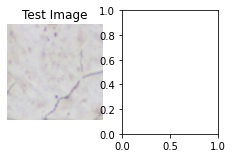

In [88]:
# Visualizing after each encoder block (after droput before maxpooling)
# layer_name = 'conv2d_144'
encoder_outputs = ['dropout_35', 'dropout_36', 'dropout_37', 'dropout_38', 'dropout_39']
decoder_outputs = ['dropout_40', 'dropout_41', 'dropout_42', 'dropout_43', 'conv2d_144']
# grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),layer_name)
# grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)


plt.figure(figsize=(12, 5))
ax = plt.subplot(261)
plt.imshow(img)
plt.axis('off')
plt.title('Test Image')

#Encoder Block
ax = plt.subplot(262)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),encoder_outputs[0])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Encoder Block-1')
ax = plt.subplot(263)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),encoder_outputs[1])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Encoder Block-2')
ax = plt.subplot(264)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),encoder_outputs[2])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Encoder Block-3')
ax = plt.subplot(265)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),encoder_outputs[3])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Encoder Block-4')
ax = plt.subplot(266)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),encoder_outputs[4])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Bottleneck')

#Decoder Block
ax = plt.subplot(268)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),decoder_outputs[0])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Decoder Block-1')
ax = plt.subplot(269)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),decoder_outputs[1])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Decoder Block-2')
ax = plt.subplot(2,6,10)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),decoder_outputs[2])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Decoder Block-3')
ax = plt.subplot(2,6,11)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),decoder_outputs[3])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Decoder Block-4')
ax = plt.subplot(2,6,12)
grad_cam=GradCam(new_model,np.expand_dims(img, axis=0),decoder_outputs[4])
plt.imshow(superimpose(img, grad_cam, 0.5, emphasize=False))
plt.axis('off')
plt.title('Final 1x1 Convolution')
plt.tight_layout()

# plt.savefig(f"/home/keerthanaprasad/RajithaKV/Residual Attention Images/Feature Visualization/eg3_featurevis_attres_dec_wpc1.png")